In [ ]:
!pip install xgboost --quiet
!pip install kagglehub --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

print('All libraries imported successfully')

✅ All libraries imported successfully


In [ ]:
import kagglehub
import os

path = kagglehub.dataset_download('noordeen/insurance-premium-prediction')
print('Path to dataset files:', path)

for file in os.listdir(path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(path, file))
        print(f' Loaded: {file}')
        break

print(f'Shape: {df.shape}')
df.head()

100%|██████████| 13.4k/13.4k [00:00<00:00, 10.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/noordeen/insurance-premium-prediction/versions/1
✅ Loaded: insurance.csv
Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [ ]:
print(' Dataset Info ')
df.info()
print('\nSummary Statistics ')
df.describe()

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

=== Summary Statistics ===


,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [ ]:
print(' Missing Values ')
print(df.isnull().sum())
print('\n Categorical Columns ')
for col in ['sex', 'smoker', 'region']:
    print(f'{col}: {df[col].unique()}')

=== Missing Values ===
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

=== Categorical Columns ===
sex: ['female' 'male']
smoker: ['yes' 'no']
region: ['southwest' 'southeast' 'northwest' 'northeast']


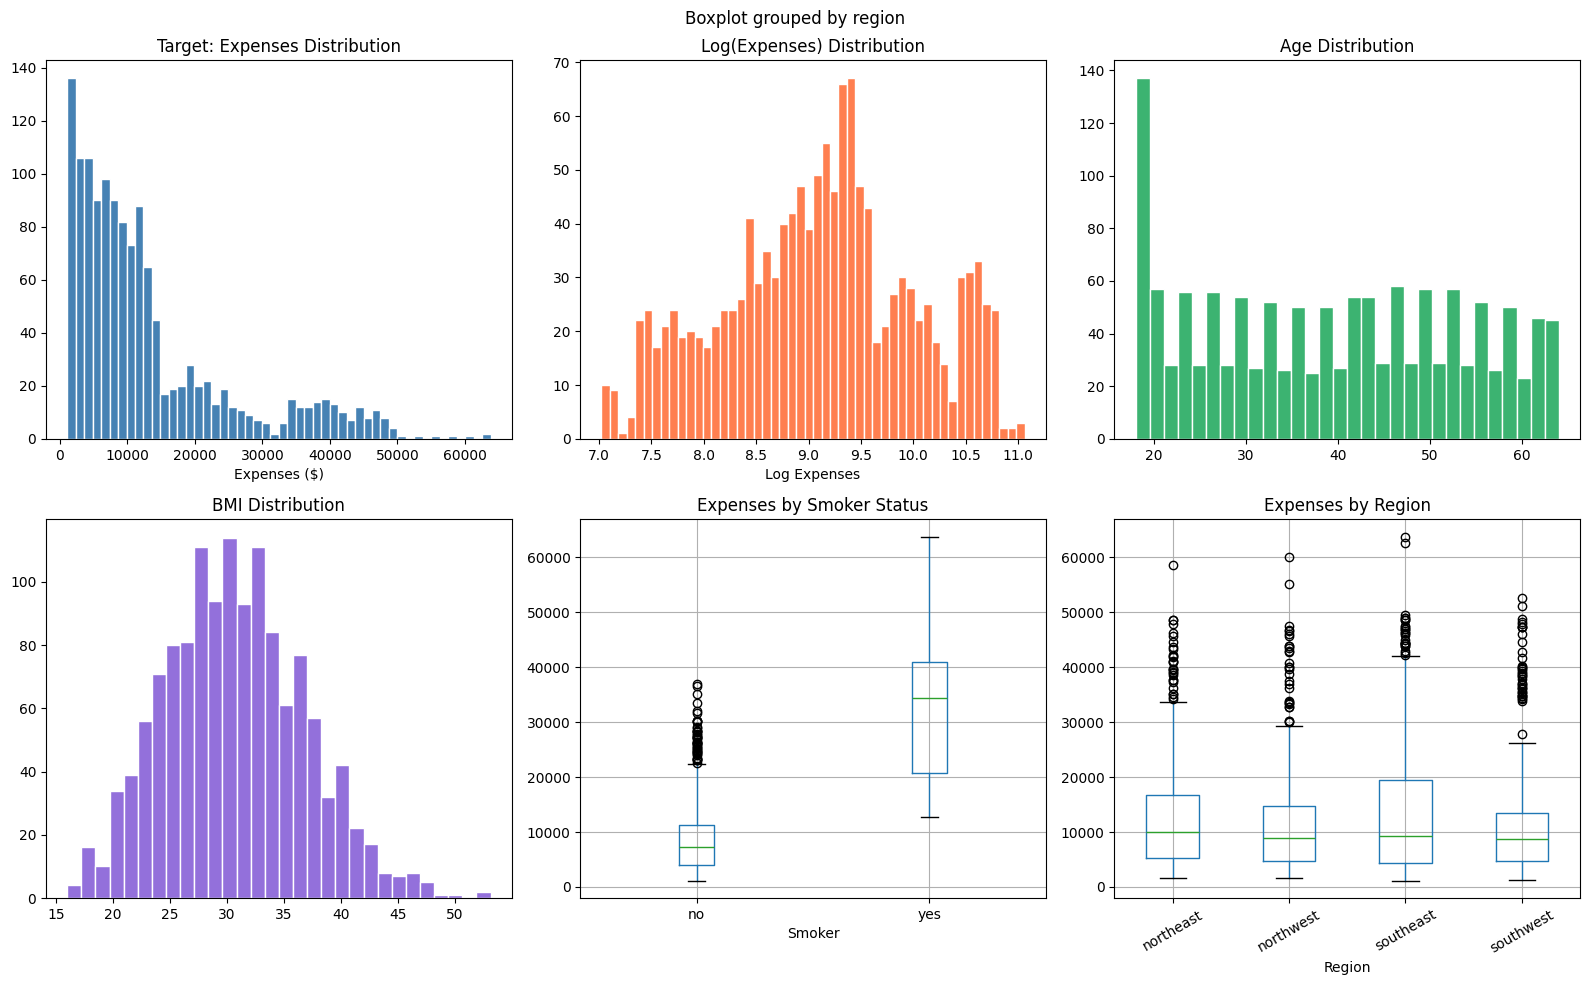

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Feature Distributions', fontsize=16, fontweight='bold')

# Expenses distribution
axes[0,0].hist(df['expenses'], bins=50, color='steelblue', edgecolor='white')
axes[0,0].set_title('Target: Expenses Distribution')
axes[0,0].set_xlabel('Expenses ($)')

# Log expenses (shows skewness correction)
axes[0,1].hist(np.log1p(df['expenses']), bins=50, color='coral', edgecolor='white')
axes[0,1].set_title('Log(Expenses) Distribution')
axes[0,1].set_xlabel('Log Expenses')

# Age distribution
axes[0,2].hist(df['age'], bins=30, color='mediumseagreen', edgecolor='white')
axes[0,2].set_title('Age Distribution')

# BMI distribution
axes[1,0].hist(df['bmi'], bins=30, color='mediumpurple', edgecolor='white')
axes[1,0].set_title('BMI Distribution')

# Smoker vs expenses
df.boxplot(column='expenses', by='smoker', ax=axes[1,1])
axes[1,1].set_title('Expenses by Smoker Status')
axes[1,1].set_xlabel('Smoker')

# Region vs expenses
df.boxplot(column='expenses', by='region', ax=axes[1,2])
axes[1,2].set_title('Expenses by Region')
axes[1,2].set_xlabel('Region')
axes[1,2].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

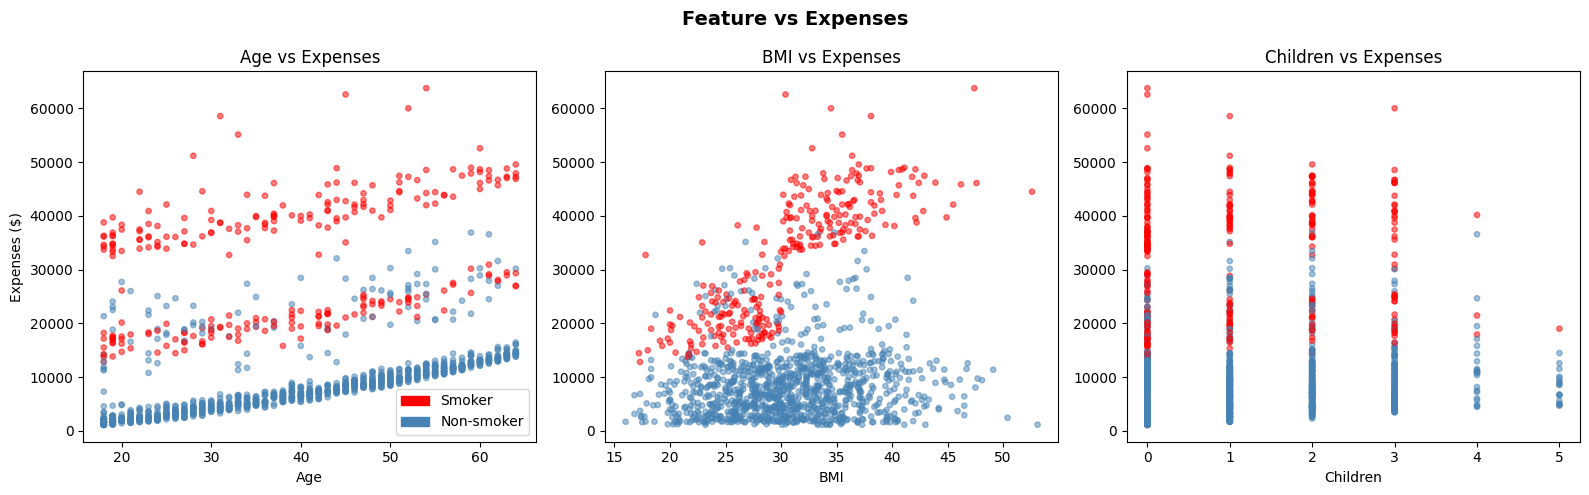

In [ ]:
# Scatter plots: features vs expenses
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Feature vs Expenses', fontsize=14, fontweight='bold')

colors = df['smoker'].map({'yes': 'red', 'no': 'steelblue'})

axes[0].scatter(df['age'], df['expenses'], c=colors, alpha=0.5, s=15)
axes[0].set_title('Age vs Expenses')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Expenses ($)')

axes[1].scatter(df['bmi'], df['expenses'], c=colors, alpha=0.5, s=15)
axes[1].set_title('BMI vs Expenses')
axes[1].set_xlabel('BMI')

axes[2].scatter(df['children'], df['expenses'], c=colors, alpha=0.5, s=15)
axes[2].set_title('Children vs Expenses')
axes[2].set_xlabel('Children')

# Legend
from matplotlib.patches import Patch
legend = [Patch(color='red', label='Smoker'), Patch(color='steelblue', label='Non-smoker')]
axes[0].legend(handles=legend)

plt.tight_layout()
plt.show()

## 🔧 4. Feature Engineering

In [ ]:
def add_features(data):
    df = data.copy()

    # Age group — buckets age into life stages
    def age_group(age):
        if age < 25:   return 'young'
        elif age < 45: return 'adult'
        elif age < 65: return 'middle_age'
        else:          return 'senior'

    def lifestyle_risk(row):
        is_smoker = row['smoker'] == 'yes'
        if is_smoker and row['bmi'] > 30:    return 'high'
        elif is_smoker and row['bmi'] > 25:  return 'medium'
        elif is_smoker:                      return 'low_smoker'
        else:                                return 'low'

    # BMI category
    def bmi_category(bmi):
        if bmi < 18.5:  return 'underweight'
        elif bmi < 25:  return 'normal'
        elif bmi < 30:  return 'overweight'
        else:           return 'obese'

    df['age_group']      = df['age'].apply(age_group)
    df['lifestyle_risk'] = df.apply(lifestyle_risk, axis=1)
    df['bmi_category']   = df['bmi'].apply(bmi_category)

    # Interaction features — combinations that help the model
    df['age_bmi']      = df['age'] * df['bmi']
    df['smoker_bmi']   = (df['smoker'] == 'yes').astype(int) * df['bmi']
    df['smoker_age']   = (df['smoker'] == 'yes').astype(int) * df['age']

    return df

# Apply to full dataframe
df_feat = add_features(df)
print(f'Original shape : {df.shape}')
print(f'After engineering: {df_feat.shape}')
df_feat.head()

Original shape : (1338, 7)
After engineering: (1338, 13)


,age,sex,bmi,children,smoker,region,expenses,age_group,lifestyle_risk,bmi_category,age_bmi,smoker_bmi,smoker_age
0,19,female,27.9,0,yes,southwest,16884.92,young,medium,overweight,530.1,27.9,19
1,18,male,33.8,1,no,southeast,1725.55,young,low,obese,608.4,0.0,0
2,28,male,33.0,3,no,southeast,4449.46,adult,low,obese,924.0,0.0,0
3,33,male,22.7,0,no,northwest,21984.47,adult,low,normal,749.1,0.0,0
4,32,male,28.9,0,no,northwest,3866.86,adult,low,overweight,924.8,0.0,0


In [ ]:
# All features including engineered ones
X = df_feat[['age', 'bmi', 'children', 'sex', 'smoker', 'region',
             'age_group', 'lifestyle_risk', 'bmi_category',
             'age_bmi', 'smoker_bmi', 'smoker_age']]

y = df_feat['expenses']

categorical_features = ['sex', 'smoker', 'region', 'age_group', 'lifestyle_risk', 'bmi_category']
numeric_features     = ['age', 'bmi', 'children', 'age_bmi', 'smoker_bmi', 'smoker_age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Train: {X_train.shape[0]} rows')
print(f'Test : {X_test.shape[0]} rows')

Train: 1070 rows
Test : 268 rows


In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', 'passthrough', numeric_features)
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
print('✅ Model trained')

✅ Model trained


In [ ]:
y_pred = rf_pipeline.predict(X_test)

r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R² Score : {r2:.4f}  → model explains {r2*100:.1f}% of variance')
print(f'MAE      : ${mae:,.2f}  → average prediction error')
print(f'RMSE     : ${rmse:,.2f}  → penalizes large errors more')

R² Score : 0.8734  → model explains 87.3% of variance
MAE      : $2,372.33  → average prediction error
RMSE     : $4,432.55  → penalizes large errors more


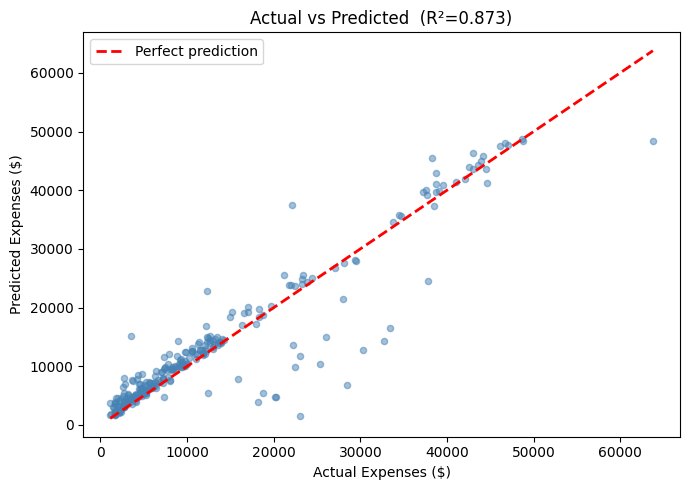

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='steelblue', s=20)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect prediction')
plt.xlabel('Actual Expenses ($)')
plt.ylabel('Predicted Expenses ($)')
plt.title(f'Actual vs Predicted  (R²={r2:.3f})')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Saves full pipeline — preprocessor + model together
joblib.dump(rf_pipeline, 'insurance_rf_model.pkl(1)')
print('✅ Saved: insurance_rf_model.pkl')

✅ Saved: insurance_rf_model.pkl


In [ ]:
# Load saved model
model = joblib.load('insurance_rf_model.pkl')

# UI only collects these 6 inputs from user
# add_features() engineers the rest internally
new_raw = pd.DataFrame({
    'age':      [21],
    'bmi':      [27.5],
    'children': [0],
    'sex':      ['female'],
    'smoker':   ['no'],
    'region':   ['southwest']
})

# Apply same feature engineering before predicting
new_data = add_features(new_raw)

# Select same columns as training
new_data = new_data[['age', 'bmi', 'children', 'sex', 'smoker', 'region',
                      'age_group', 'lifestyle_risk', 'bmi_category',
                      'age_bmi', 'smoker_bmi', 'smoker_age']]

pred = model.predict(new_data)
print(f'Predicted Insurance Expense: ${pred[0]:,.2f}')

Predicted Insurance Expense: $2,193.52
